In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Obtain the imdb review dataset from tensorflow datasets
dataset = tfds.load('imdb_reviews', as_supervised=True)

# Preprocessing function to handle text and labels
def preprocess(text, label):
    return tf.expand_dims(text, -1), tf.cast(label, tf.float32)

# Seperate test and train datasets
train_dataset, test_dataset = dataset['train'], dataset['test']

# Split the test and train data into batches of 32 and shuffling the training set
batch_size = 32
train_dataset = dataset['train'].map(preprocess).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.V0Q4OC_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.V0Q4OC_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.V0Q4OC_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
example, label = next(iter(train_dataset))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])

Text:
 [b'I had never read Gary Paulsen\'s novel, Hatchet, for which \'A Cry in the Wild\' is the adaptation of, so I can\'t make any comparisons to the book. I will, however, say that as a film on its own, adaptation or no adaptation, it was an underdeveloped adventure that provides no major explanation of its few characters.<br /><br />Think of \'A Cry in the Wild\' as a less luxurious, teenage mountaineer (was Quincy, California the only place this was filmed?) version of \'Cast Away.\' Jared Rushton is 13-year-old Brian Roebson, a kid headed on a small plane to visit his father, until the craft crashes over some deserted mountain terrain, leaving the kid stranded for quite a while and having to defend himself.<br /><br />There are basically three parts to the film. The obvious being the ten or fifteen minute introduction of the characters, namely Brian and his mom. <br /><br />The next third of the movie (which really consumes nearly all of the film) is that of Brian "roughing it."

In [4]:
# Using the TextVectorization layer to normalize, split, and map strings to integers.
encoder = tf.keras.layers.TextVectorization(max_tokens=10000, output_mode='int')
encoder.adapt(train_dataset.map(lambda text, label: text))

In [5]:
# Creating the model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(None,), dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Summary of the model
model.summary()

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 64)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, None, 128)           │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Training the model and validating it on the test set
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1935s 2s/step - accuracy: 0.7335 - loss: 0.4773 - val_accuracy: 0.8182 - val_loss: 0.3363
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1966s 2s/step - accuracy: 0.9149 - loss: 0.2094 - val_accuracy: 0.8686 - val_loss: 0.3086
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1939s 2s/step - accuracy: 0.9470 - loss: 0.1358 - val_accuracy: 0.8710 - val_loss: 0.3594
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1935s 2s/step - accuracy: 0.9696 - loss: 0.0820 - val_accuracy: 0.8666 - val_loss: 0.4349
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1961s 3s/step - accuracy: 0.9809 - loss: 0.0527 - val_accuracy: 0.8397 - val_loss: 0.7059


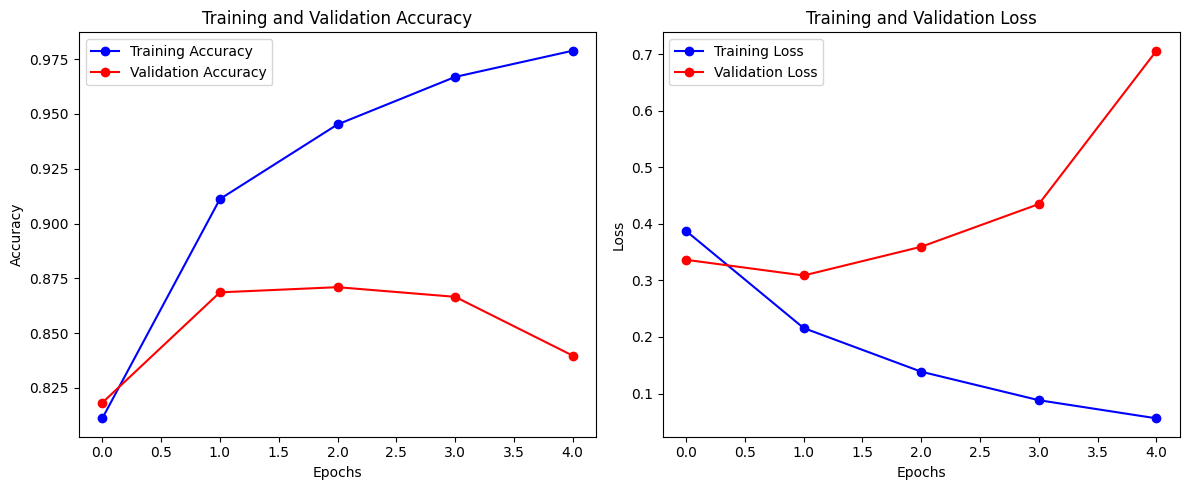

In [7]:
# Plotting the accuracy and loss over time
# Training history
history_dict = history.history

# Separating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Separating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting accuracy and loss
plt.figure(figsize=(12, 5))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, 'bo-', label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, 'bo-', label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [8]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

# Print the accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


782/782 ━━━━━━━━━━━━━━━━━━━━ 298s 382ms/step - accuracy: 0.8404 - loss: 0.6955
Test Accuracy: 83.97%
